In [10]:
import comet_ml

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm

import mutils

In [11]:
comet_api = comet_ml.api.API()

In [12]:
exps = comet_api.get("transformer/asha-bayes-bs4")

In [18]:
errors = []
all_dfs = {}
for exp in tqdm(exps):
    meta = exp.get_metadata()
    start_time = dt.datetime.fromtimestamp(meta['startTimeMillis']/1000.0)
    end_time = dt.datetime.fromtimestamp(meta['endTimeMillis']/1000.0)

    try:
        df = mutils.get_exp_csv(exp.id)
    except FileNotFoundError as e:
        errors.append(e)
    df = mutils.get_epoch_info(df)
    df['dt'] = pd.date_range(start_time, end_time, len(df['valid_1mae']))
    all_dfs[exp.id] = df

100%|██████████| 32/32 [00:06<00:00,  4.81it/s]


In [19]:
completed_dfs = {k: df for k, df in all_dfs.items() if len(df) > 4}
dfs = all_dfs

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


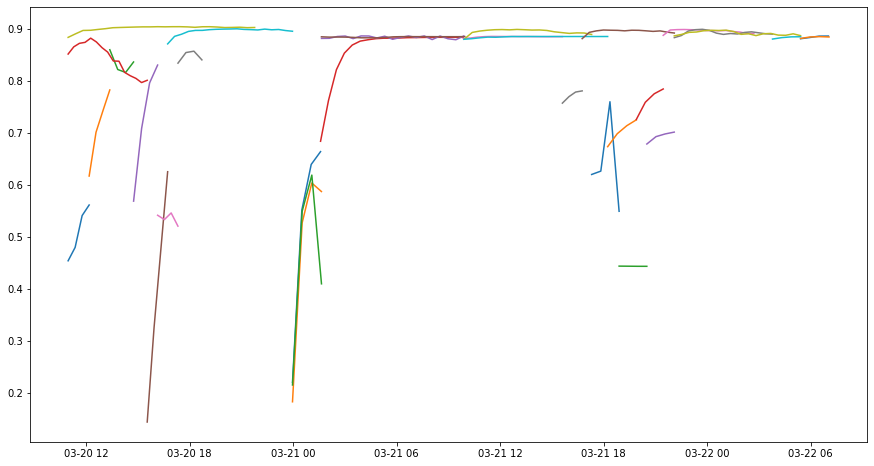

In [20]:
plt.rcParams["figure.figsize"] = (15,8)
for df in dfs.values():
    plt.plot(df['dt'], df['valid_1mae'])
# plt.ylim(0.88, 0.905)
plt.show()

In [21]:
maes = []
dt_stamps = []
dts = []
for k, df in dfs.items():
    i = df['valid_1mae'].argmax()
    maes.append(df['valid_1mae'].iloc[i])
    dt_stamps.append(df['dt'].iloc[i].timestamp())
    dts.append(df['dt'].iloc[i])

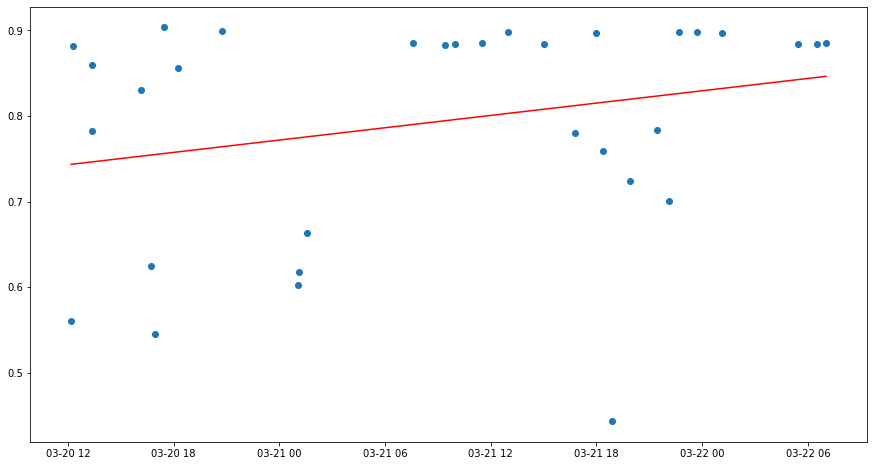

In [22]:
x = dt_stamps
y = maes
df = pd.DataFrame({'x': np.unique(dts), 'y': np.poly1d(np.polyfit(x, y, 1))(np.unique(x))})
plt.plot(df['x'], df['y'], color='r')
df = pd.DataFrame({'dt': dts, 'valid_1mae': maes})
plt.scatter(df['dt'], df['valid_1mae'])
# plt.ylim(0.88, 0.905)
plt.show()

In [23]:
dt_sorted = sorted(list(zip(dts, maes)))
dt_sorted_mae = [mae for _, mae in dt_sorted]
dt_sorted_st = [dt for dt, _ in dt_sorted]

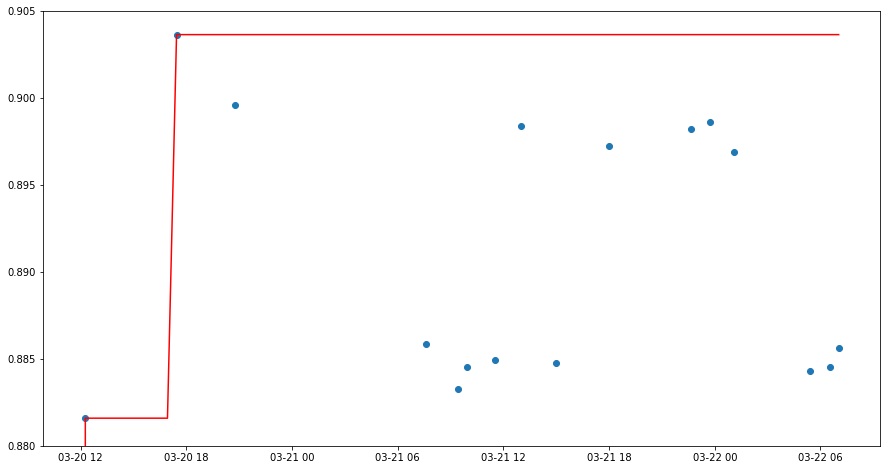

In [24]:
max_acc_mae = np.maximum.accumulate(dt_sorted_mae)
df = pd.DataFrame({'x': dt_sorted_st, 'y': max_acc_mae})
plt.plot(df['x'], df['y'], color='r')
df = pd.DataFrame({'x': dts, 'y': maes})
plt.scatter(df['x'], df['y'])
plt.ylim(0.88, 0.905)
plt.show()

In [25]:
print(f'Number of experiment: {len(dfs)}.')
print(f'Best valid mae: {max_acc_mae[-1]:.4f}.')

Number of experiment: 32.
Best valid mae: 0.9036.


# TODO

how do hyperparameters change?

In [3]:
from pathlib import Path
from pytorch_lightning.core.saving import load_hparams_from_yaml

In [30]:
hparams = []
for k, df in all_dfs.items():
    f = Path('logs') / 'csv' / k / 'version_0' / 'hparams.yaml'
    hparams.append(load_hparams_from_yaml(f))

In [47]:
summary = []
for hp, mae, dt, dt_stamp in zip(hparams, maes, dts, dt_stamps):
    combined = hp
    combined['best_valid_1mae'] = mae
    combined['dt'] = dt
    combined['dt_stamp'] = dt_stamp
    summary.append(combined)

In [48]:
summary = pd.DataFrame(summary)

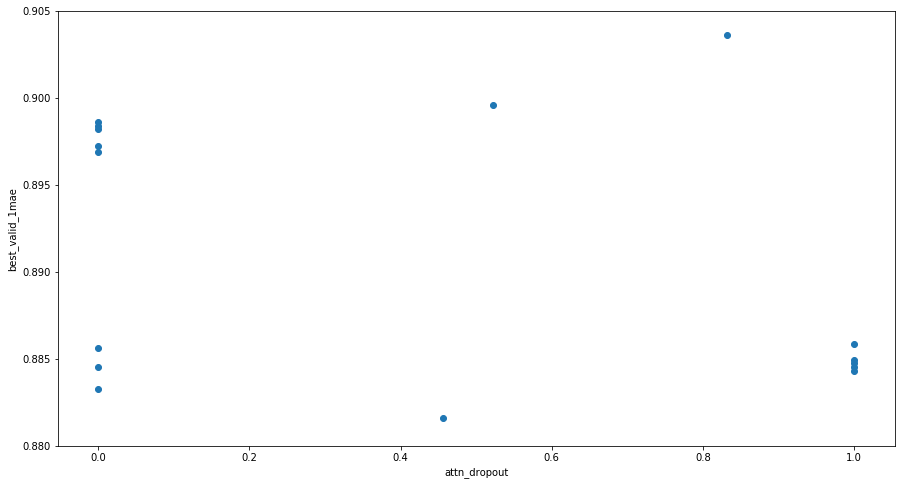

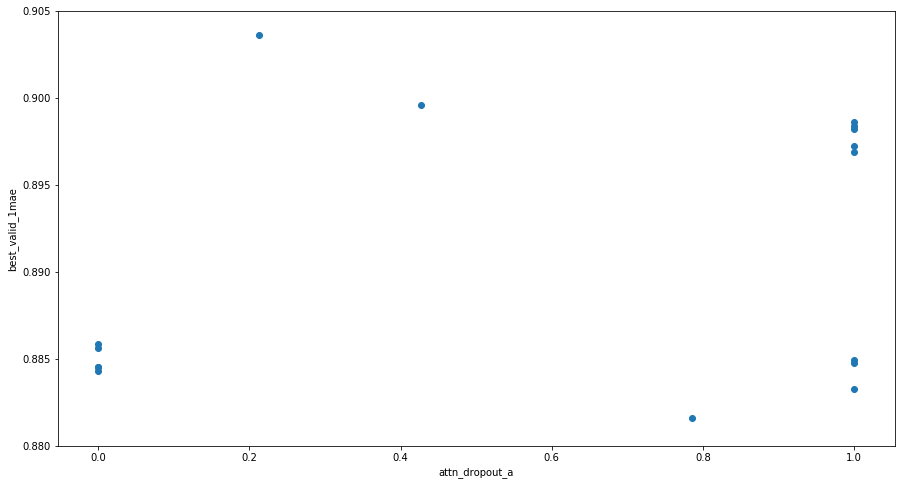

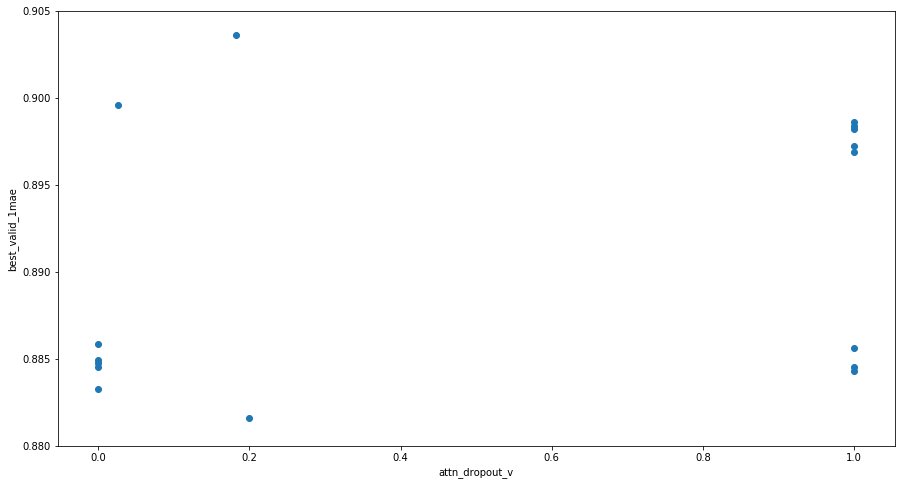

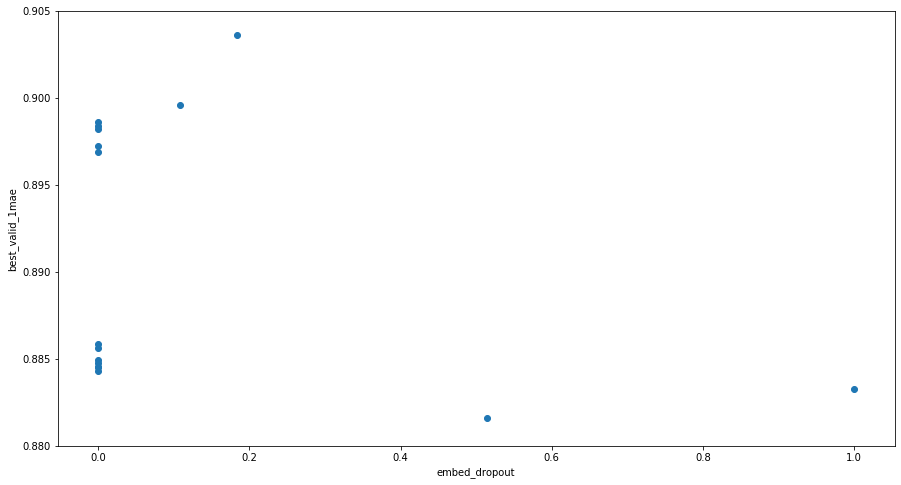

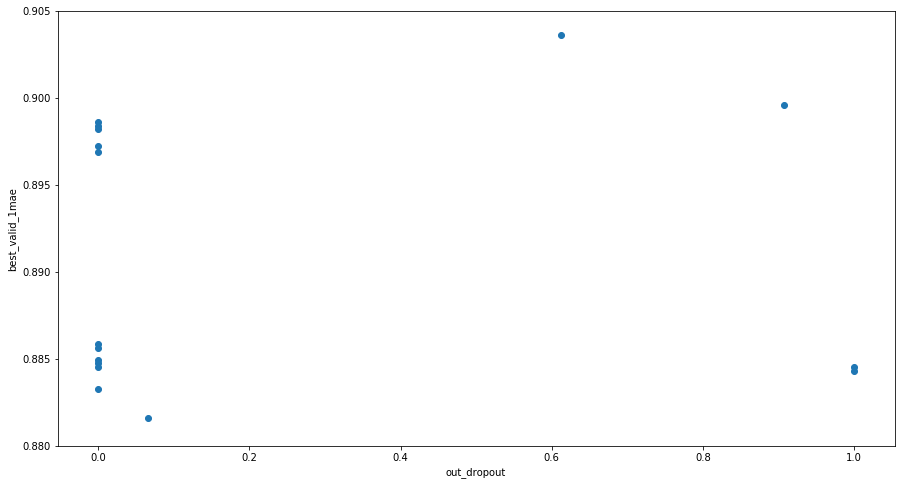

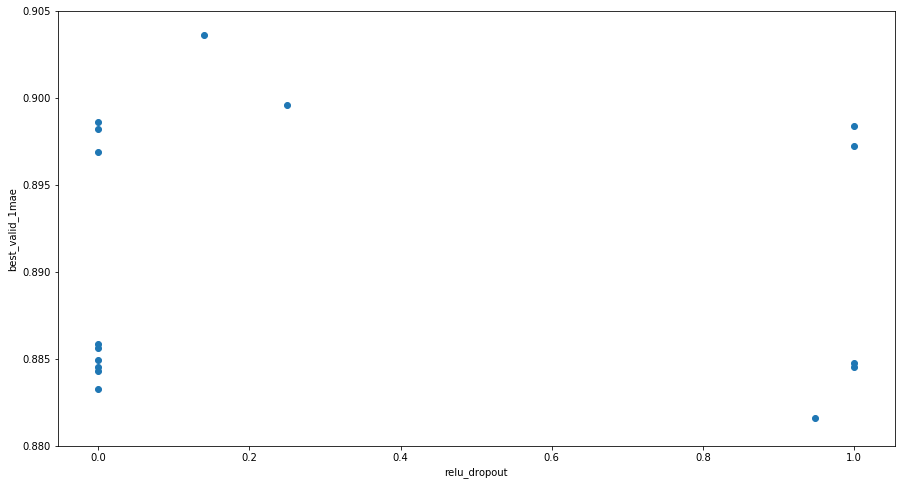

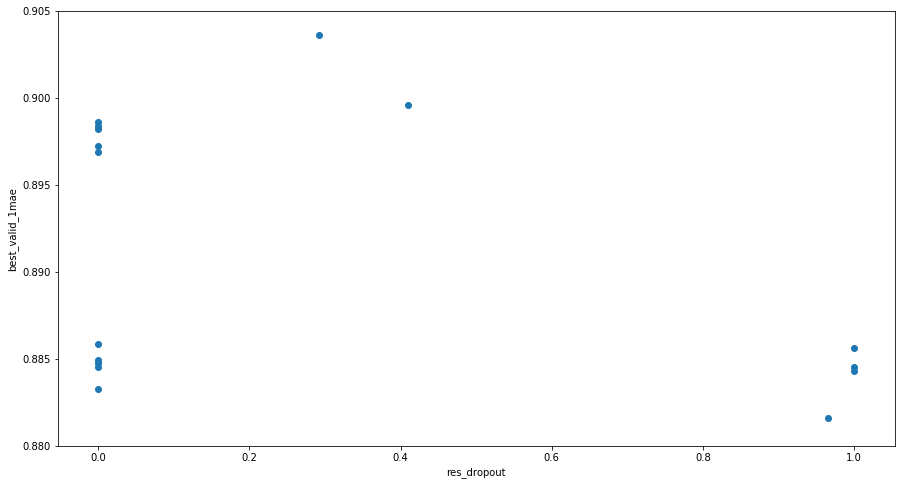

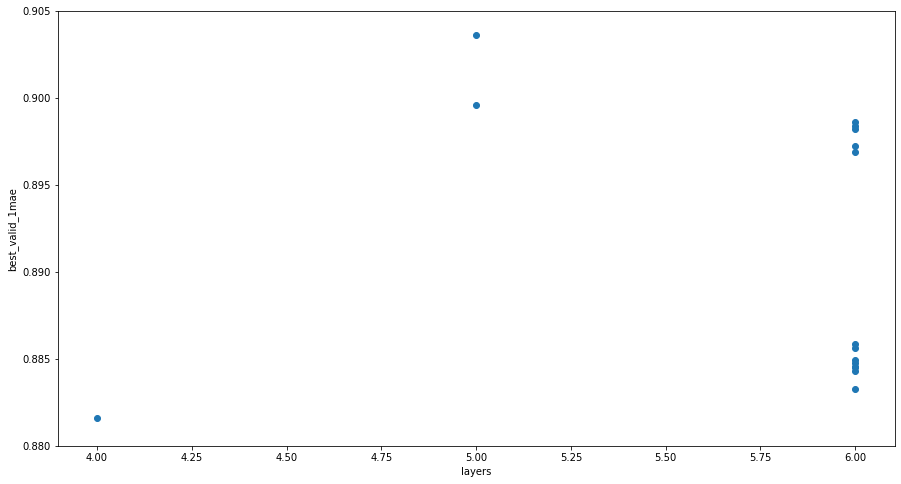

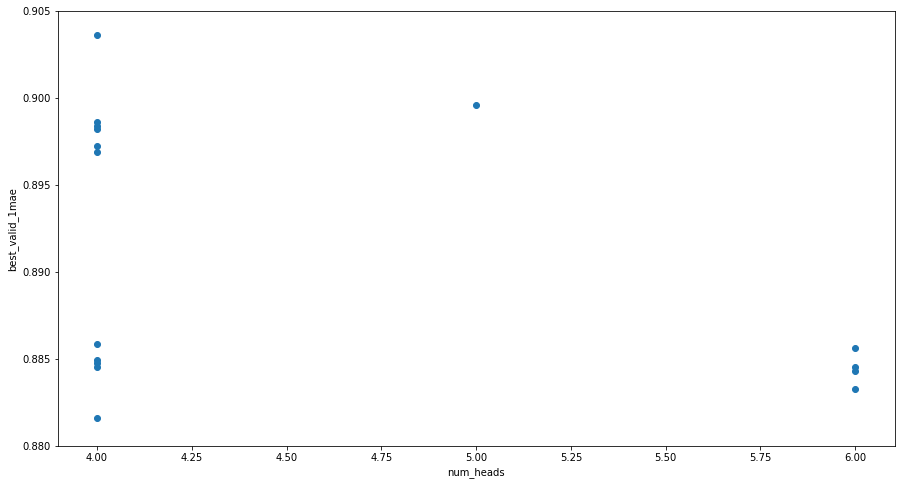

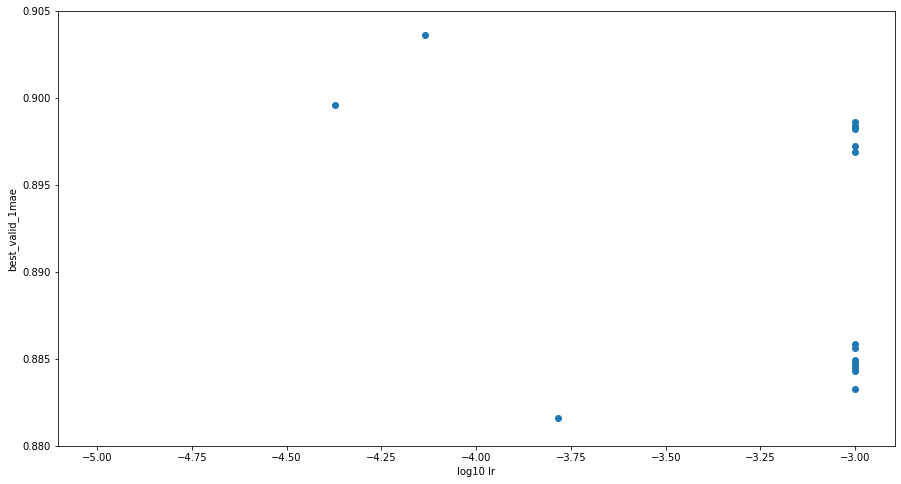

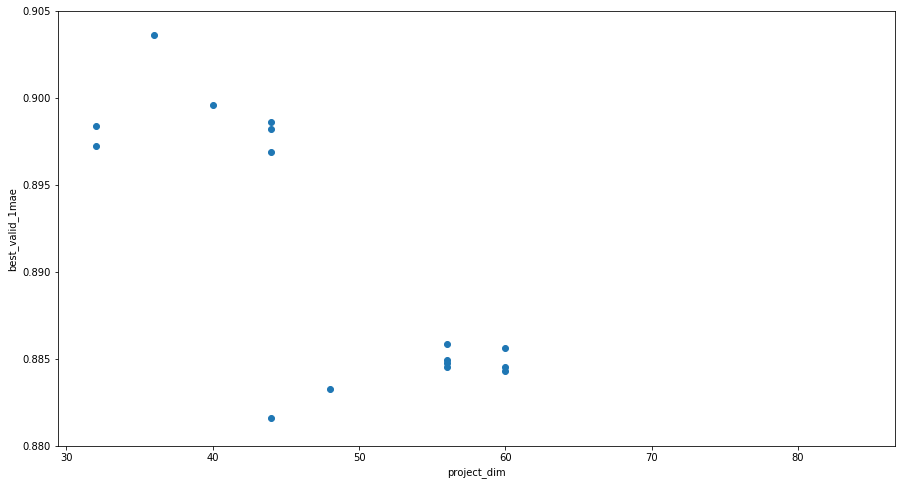

In [57]:
hparam = 'project_dim'
for hparam in ["attn_dropout","attn_dropout_a","attn_dropout_v","embed_dropout","out_dropout","relu_dropout","res_dropout","layers","num_heads","lr","project_dim"]:
    if hparam == 'lr':
        plt.scatter(np.log10(summary[hparam]), summary['best_valid_1mae'])
        plt.xlabel('log10 lr')
    else:
        plt.scatter(summary[hparam], summary['best_valid_1mae'])
        plt.xlabel(hparam)
    plt.ylabel('best_valid_1mae')
    plt.ylim(0.88, 0.905)
    plt.show()
# plt.scatter(summary['dt_stamp'], summary[hparam])
# plt.xlabel('time')
# plt.ylabel(hparam)
# plt.show()